# Introdução à Aprendizagem de Máquina - Trabalho Final

## 1. A base de dados "A Large Scale Fish Dataset"

In [9]:
import kaggle
import pathlib

In [12]:
wd = pathlib.Path().absolute().as_posix()

kaggle.api.authenticate()
kaggle.api.dataset_download_files('crowww/a-large-scale-fish-dataset', path=wd+'/dataset', unzip=True)

## 2. Implementação original do baseline, utilizando DenseNet implementado em Keras

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [27]:
image_dir = Path('dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]
image_df

,Filepath,Label
0,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
1,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
2,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
3,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
4,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
...,...,...
16995,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16996,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16997,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16998,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout


In [28]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
1,dataset/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel
2,dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea...,Sea Bass


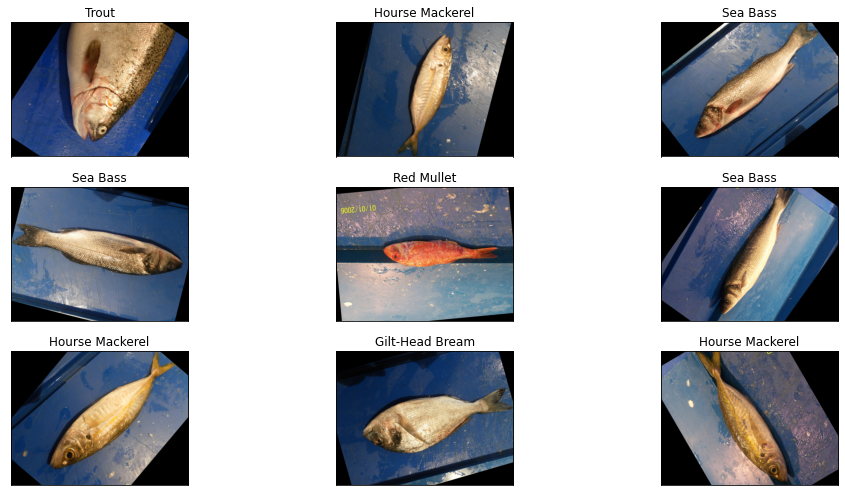

In [29]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [30]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [31]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [32]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [33]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [35]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
203/203 [==============================] - 370s 2s/step - loss: 0.5078 - accuracy: 0.8465 - val_loss: 0.0413 - val_accuracy: 0.9864
Epoch 2/50
203/203 [==============================] - 346s 2s/step - loss: 0.0173 - accuracy: 0.9947 - val_loss: 0.0517 - val_accuracy: 0.9833
Epoch 3/50
203/203 [==============================] - 344s 2s/step - loss: 0.0151 - accuracy: 0.9947 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 4/50
203/203 [==============================] - 334s 2s/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0077 - val_accuracy: 0.9981
Epoch 5/50
203/203 [==============================] - 325s 2s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0054 - val_accuracy: 0.9981


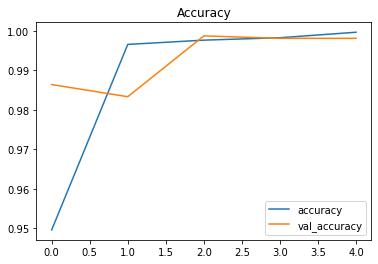

In [36]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

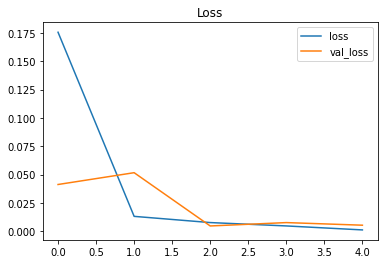

In [37]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [38]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00860
Test Accuracy: 99.89%


In [39]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Trout', 'Shrimp', 'Trout', 'Striped Red Mullet', 'Black Sea Sprat']


In [40]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       104
   Gilt-Head Bream       1.00      1.00      1.00        94
   Hourse Mackerel       1.00      1.00      1.00       104
        Red Mullet       1.00      0.99      1.00       107
     Red Sea Bream       1.00      1.00      1.00       101
          Sea Bass       1.00      1.00      1.00        93
            Shrimp       1.00      1.00      1.00        96
Striped Red Mullet       0.99      1.00      0.99        92
             Trout       1.00      1.00      1.00       109

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



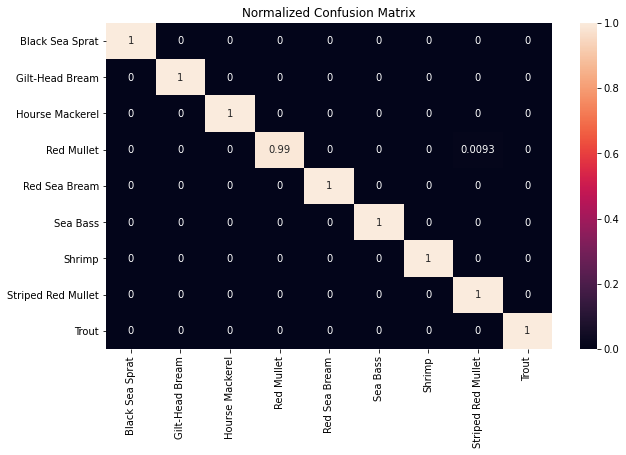

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

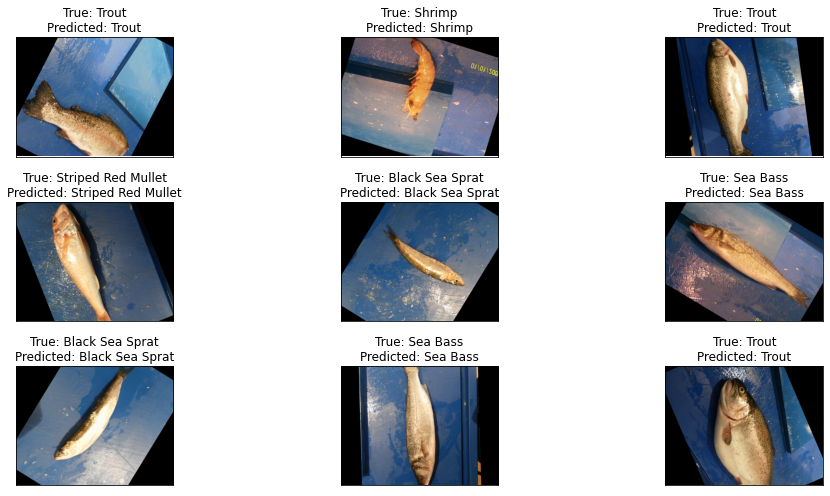

In [44]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## 3. Implementação do baseline, utilizando DenseNet implementado em PyTorch

## 4. Classificação com o uso de SVM

In [3]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [16]:
from skimage.feature import hog
from skimage.color import rgb2gray
from pathlib import Path

In [7]:
image_dir = Path('dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]
image_df

,Filepath,Label
0,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
1,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
2,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
3,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
4,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
...,...,...
16995,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16996,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16997,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16998,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout


In [29]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)
image_df

,Filepath,Label
0,dataset/Fish_Dataset/Fish_Dataset/Striped Red ...,Striped Red Mullet
1,dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Br...,Gilt-Head Bream
2,dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Br...,Gilt-Head Bream
3,dataset/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel
4,dataset/Fish_Dataset/Fish_Dataset/Red Mullet/R...,Red Mullet
...,...,...
8995,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
8996,dataset/Fish_Dataset/Fish_Dataset/Red Mullet/R...,Red Mullet
8997,dataset/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel
8998,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout


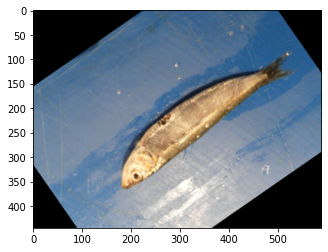

In [14]:
labels = image_df['Label']

labels.unique()

def get_image(file_path):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    img = Image.open(file_path)
    return np.array(img)

# # subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
# apis_row = labels[labels.genus == 0.0].index[5]

# # show the corresponding image of an Apis
# plt.imshow(get_image(apis_row))
# plt.show()

# # subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
# bombus_row = labels[labels.genus == 1.0].index[6]
fish_row = image_df['Filepath'].iloc[0]
plt.imshow(get_image(fish_row))
plt.show()

Color fish image has shape:  [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Greyscale fish image has shape:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


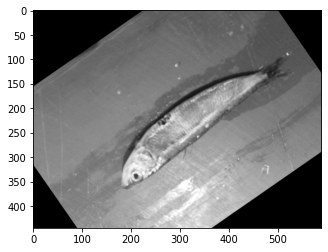

In [18]:
# load a fish image using our get_image function and bombus_row from the previous cell
fish = get_image(fish_row)

print('Color fish image has shape: ', fish)

# convert the bombus image to greyscale
gray_fish = rgb2gray(fish)

plt.imshow(grey_fish, cmap=mpl.cm.gray)

print('Greyscale fish image has shape: ', gray_fish)

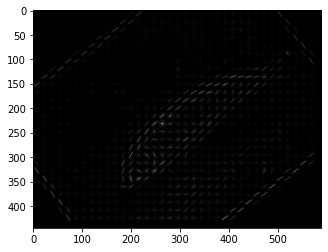

In [23]:
# run HOG using our grayscale fish image
hog_features, hog_image = hog(gray_fish,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)

In [24]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    gray_image = rgb2gray(img)
    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

fish_features = create_features(fish)

print(fish_features)

[0 0 0 ... 0 0 0]


In [37]:
len(image_df)

9000

In [ ]:
import progressbar
barlen = len(image_df)

def create_feature_matrix(label_dataframe):
    features_list = []
    bar = progressbar.ProgressBar(maxval=len(label_dataframe), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i=0
    for img_path in label_dataframe['Filepath']:
        # load image
        img = get_image(img_path)
        print(f"got image {i}")
        # get features for image
        image_features = create_features(img)
        print(f"got features of image {i}")
        features_list.append(image_features)
        bar.update(i+1)
        i += 1
    bar.finish()
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(image_df)

got image 0
got features of image 0
got image 1
got features of image 1
got image 2
got features of image 2
got image 3
got features of image 3
got image 4
got features of image 4
got image 5
got features of image 5
got image 6
got features of image 6
got image 7
got features of image 7
got image 8
got features of image 8
got image 9
got features of image 9
got image 10
got features of image 10
got image 11
got features of image 11
got image 12
got features of image 12
got image 13
got features of image 13
got image 14
got features of image 14
got image 15
got features of image 15
got image 16
got features of image 16
got image 17
got features of image 17
got image 18
got features of image 18
got image 19
got features of image 19
got image 20
got features of image 20
got image 21
got features of image 21
got image 22
got features of image 22
got image 23
got features of image 23
got image 24
got features of image 24
got image 25
got features of image 25
got image 26
got features of ima

got features of image 89
got image 90
got features of image 90
got image 91
got features of image 91
got image 92
got features of image 92
got image 93
got features of image 93
got image 94
got features of image 94
got image 95
got features of image 95
got image 96
got features of image 96
got image 97
got features of image 97
got image 98
got features of image 98
got image 99
got features of image 99
got image 100
got features of image 100
got image 101
got features of image 101
got image 102
got features of image 102
got image 103
got features of image 103
got image 104
got features of image 104
got image 105
got features of image 105
got image 106
got features of image 106
got image 107
got features of image 107
got image 108
got features of image 108
got image 109
got features of image 109
got image 110
got features of image 110
got image 111
got features of image 111
got image 112
got features of image 112
got image 113
got features of image 113
got image 114
got features of image

got features of image 179
got image 180
got features of image 180
got image 181
got features of image 181
got image 182
got features of image 182
got image 183
got features of image 183
got image 184
got features of image 184
got image 185
got features of image 185
got image 186
got features of image 186
got image 187
got features of image 187
got image 188
got features of image 188
got image 189
got features of image 189
got image 190
got features of image 190
got image 191
got features of image 191
got image 192
got features of image 192
got image 193
got features of image 193
got image 194
got features of image 194
got image 195
got features of image 195
got image 196
got features of image 196
got image 197
got features of image 197
got image 198
got features of image 198
got image 199
got features of image 199
got image 200
got features of image 200
got image 201
got features of image 201
got image 202
got features of image 202
got image 203
got features of image 203
got image 204


got features of image 269
got image 270
got features of image 270
got image 271
got features of image 271
got image 272
got features of image 272
got image 273
got features of image 273
got image 274
got features of image 274
got image 275
got features of image 275
got image 276
got features of image 276
got image 277
got features of image 277
got image 278
got features of image 278
got image 279
got features of image 279
got image 280
got features of image 280
got image 281
got features of image 281
got image 282
got features of image 282
got image 283
got features of image 283
got image 284
got features of image 284
got image 285
got features of image 285
got image 286
got features of image 286
got image 287
got features of image 287
got image 288
got features of image 288
got image 289
got features of image 289
got image 290
got features of image 290
got image 291
got features of image 291
got image 292
got features of image 292
got image 293
got features of image 293
got image 294


got features of image 359
got image 360
got features of image 360
got image 361
got features of image 361
got image 362
got features of image 362
got image 363
got features of image 363
got image 364
got features of image 364
got image 365
got features of image 365
got image 366
got features of image 366
got image 367
got features of image 367
got image 368
got features of image 368
got image 369
got features of image 369
got image 370
got features of image 370
got image 371
got features of image 371
got image 372
got features of image 372
got image 373
got features of image 373
got image 374
got features of image 374
got image 375
got features of image 375
got image 376
got features of image 376
got image 377
got features of image 377
got image 378
got features of image 378
got image 379
got features of image 379
got image 380
got features of image 380
got image 381
got features of image 381
got image 382
got features of image 382
got image 383
got features of image 383
got image 384


got features of image 449
got image 450
got features of image 450
got image 451
got features of image 451
got image 452
got features of image 452
got image 453
got features of image 453
got image 454
got features of image 454
got image 455
got features of image 455
got image 456
got features of image 456
got image 457
got features of image 457
got image 458
got features of image 458
got image 459
got features of image 459
got image 460
got features of image 460
got image 461
got features of image 461
got image 462
got features of image 462
got image 463
got features of image 463
got image 464
got features of image 464
got image 465
got features of image 465
got image 466
got features of image 466
got image 467
got features of image 467
got image 468
got features of image 468
got image 469
got features of image 469
got image 470
got features of image 470
got image 471
got features of image 471
got image 472
got features of image 472
got image 473
got features of image 473
got image 474


got features of image 539
got image 540
got features of image 540
got image 541
got features of image 541
got image 542
got features of image 542
got image 543
got features of image 543
got image 544
got features of image 544
got image 545
got features of image 545
got image 546
got features of image 546
got image 547
got features of image 547
got image 548
got features of image 548
got image 549
got features of image 549
got image 550
got features of image 550
got image 551
got features of image 551
got image 552
got features of image 552
got image 553
got features of image 553
got image 554
got features of image 554
got image 555
got features of image 555
got image 556
got features of image 556
got image 557
got features of image 557
got image 558
got features of image 558
got image 559
got features of image 559
got image 560
got features of image 560
got image 561
got features of image 561
got image 562
got features of image 562
got image 563
got features of image 563
got image 564


got features of image 629
got image 630
got features of image 630
got image 631
got features of image 631
got image 632
got features of image 632
got image 633
got features of image 633
got image 634
got features of image 634
got image 635
got features of image 635
got image 636
got features of image 636
got image 637
got features of image 637
got image 638
got features of image 638
got image 639
got features of image 639
got image 640
got features of image 640
got image 641
got features of image 641
got image 642
got features of image 642
got image 643
got features of image 643
got image 644
got features of image 644
got image 645
got features of image 645
got image 646
got features of image 646
got image 647
got features of image 647
got image 648
got features of image 648
got image 649
got features of image 649
got image 650
got features of image 650
got image 651
got features of image 651
got image 652
got features of image 652
got image 653
got features of image 653
got image 654


got features of image 719
got image 720
got features of image 720
got image 721
got features of image 721
got image 722
got features of image 722
got image 723
got features of image 723
got image 724
got features of image 724
got image 725
got features of image 725
got image 726
got features of image 726
got image 727
got features of image 727
got image 728
got features of image 728
got image 729
got features of image 729
got image 730
got features of image 730
got image 731
got features of image 731
got image 732
got features of image 732
got image 733
got features of image 733
got image 734
got features of image 734
got image 735
got features of image 735
got image 736
got features of image 736
got image 737
got features of image 737
got image 738
got features of image 738
got image 739
got features of image 739
got image 740
got features of image 740
got image 741
got features of image 741
got image 742
got features of image 742
got image 743
got features of image 743
got image 744


got features of image 809
got image 810
got features of image 810
got image 811
got features of image 811
got image 812
got features of image 812
got image 813
got features of image 813
got image 814
got features of image 814
got image 815
got features of image 815
got image 816
got features of image 816
got image 817
got features of image 817
got image 818
got features of image 818
got image 819
got features of image 819
got image 820
got features of image 820
got image 821
got features of image 821
got image 822
got features of image 822
got image 823
got features of image 823
got image 824
got features of image 824
got image 825
got features of image 825
got image 826
got features of image 826
got image 827
got features of image 827
got image 828
got features of image 828
got image 829
got features of image 829
got image 830
got features of image 830
got image 831
got features of image 831
got image 832
got features of image 832
got image 833
got features of image 833
got image 834


got features of image 899
got image 900
got features of image 900
got image 901
got features of image 901
got image 902
got features of image 902
got image 903
got features of image 903
got image 904
got features of image 904
got image 905
got features of image 905
got image 906
got features of image 906
got image 907
got features of image 907
got image 908
got features of image 908
got image 909
got features of image 909
got image 910
got features of image 910
got image 911
got features of image 911
got image 912
got features of image 912
got image 913
got features of image 913
got image 914
got features of image 914
got image 915
got features of image 915
got image 916
got features of image 916
got image 917
got features of image 917
got image 918
got features of image 918
got image 919
got features of image 919
got image 920
got features of image 920
got image 921
got features of image 921
got image 922
got features of image 922
got image 923
got features of image 923
got image 924


got features of image 989
got image 990
got features of image 990
got image 991
got features of image 991
got image 992
got features of image 992
got image 993
got features of image 993
got image 994
got features of image 994
got image 995
got features of image 995
got image 996
got features of image 996
got image 997
got features of image 997
got image 998
got features of image 998
got image 999
got features of image 999
got image 1000
got features of image 1000
got image 1001
got features of image 1001
got image 1002
got features of image 1002
got image 1003
got features of image 1003
got image 1004
got features of image 1004
got image 1005
got features of image 1005
got image 1006
got features of image 1006
got image 1007
got features of image 1007
got image 1008
got features of image 1008
got image 1009
got features of image 1009
got image 1010
got features of image 1010
got image 1011
got features of image 1011
got image 1012
got features of image 1012
got image 1013
got features 

got features of image 1079
got image 1080
got features of image 1080
got image 1081
got features of image 1081
got image 1082
got features of image 1082
got image 1083
got features of image 1083
got image 1084
got features of image 1084
got image 1085
got features of image 1085
got image 1086
got features of image 1086
got image 1087
got features of image 1087
got image 1088
got features of image 1088
got image 1089
got features of image 1089
got image 1090
got features of image 1090
got image 1091
got features of image 1091
got image 1092
got features of image 1092
got image 1093
got features of image 1093
got image 1094
got features of image 1094
got image 1095
got features of image 1095
got image 1096
got features of image 1096
got image 1097
got features of image 1097
got image 1098
got features of image 1098
got image 1099
got features of image 1099
got image 1100
got features of image 1100
got image 1101
got features of image 1101
got image 1102
got features of image 1102
got ima

got features of image 1169
got image 1170
got features of image 1170
got image 1171
got features of image 1171
got image 1172
got features of image 1172
got image 1173
got features of image 1173
got image 1174
got features of image 1174
got image 1175
got features of image 1175
got image 1176
got features of image 1176
got image 1177
got features of image 1177
got image 1178
got features of image 1178
got image 1179
got features of image 1179
got image 1180
got features of image 1180
got image 1181
got features of image 1181
got image 1182
got features of image 1182
got image 1183
got features of image 1183
got image 1184
got features of image 1184
got image 1185
got features of image 1185
got image 1186
got features of image 1186
got image 1187
got features of image 1187
got image 1188
got features of image 1188
got image 1189
got features of image 1189
got image 1190
got features of image 1190
got image 1191
got features of image 1191
got image 1192
got features of image 1192
got ima

got features of image 1259
got image 1260
got features of image 1260
got image 1261
got features of image 1261
got image 1262
got features of image 1262
got image 1263
got features of image 1263
got image 1264
got features of image 1264
got image 1265
got features of image 1265
got image 1266
got features of image 1266
got image 1267
got features of image 1267
got image 1268
got features of image 1268
got image 1269
got features of image 1269
got image 1270
got features of image 1270
got image 1271
got features of image 1271
got image 1272
got features of image 1272
got image 1273
got features of image 1273
got image 1274
got features of image 1274
got image 1275
got features of image 1275
got image 1276
got features of image 1276
got image 1277
got features of image 1277
got image 1278
got features of image 1278
got image 1279
got features of image 1279
got image 1280
got features of image 1280
got image 1281
got features of image 1281
got image 1282
got features of image 1282
got ima

got features of image 1349
got image 1350
got features of image 1350
got image 1351
got features of image 1351
got image 1352
got features of image 1352
got image 1353
got features of image 1353
got image 1354
got features of image 1354
got image 1355
got features of image 1355
got image 1356
got features of image 1356
got image 1357
got features of image 1357
got image 1358
got features of image 1358
got image 1359
got features of image 1359
got image 1360
got features of image 1360
got image 1361
got features of image 1361
got image 1362
got features of image 1362
got image 1363
got features of image 1363
got image 1364
got features of image 1364
got image 1365
got features of image 1365
got image 1366
got features of image 1366
got image 1367
got features of image 1367
got image 1368
got features of image 1368
got image 1369
got features of image 1369
got image 1370
got features of image 1370
got image 1371
got features of image 1371
got image 1372
got features of image 1372
got ima

got features of image 1439
got image 1440
got features of image 1440
got image 1441
got features of image 1441
got image 1442
got features of image 1442
got image 1443
got features of image 1443
got image 1444
got features of image 1444
got image 1445
got features of image 1445
got image 1446
got features of image 1446
got image 1447
got features of image 1447
got image 1448
got features of image 1448
got image 1449
got features of image 1449
got image 1450
got features of image 1450
got image 1451
got features of image 1451
got image 1452
got features of image 1452
got image 1453
got features of image 1453
got image 1454
got features of image 1454
got image 1455
got features of image 1455
got image 1456
got features of image 1456
got image 1457
got features of image 1457
got image 1458
got features of image 1458
got image 1459
got features of image 1459
got image 1460
got features of image 1460
got image 1461
got features of image 1461
got image 1462
got features of image 1462
got ima

got features of image 1529
got image 1530
got features of image 1530
got image 1531
got features of image 1531
got image 1532
got features of image 1532
got image 1533
got features of image 1533
got image 1534
got features of image 1534
got image 1535
got features of image 1535
got image 1536
got features of image 1536
got image 1537
got features of image 1537
got image 1538
got features of image 1538
got image 1539
got features of image 1539
got image 1540
got features of image 1540
got image 1541
got features of image 1541
got image 1542
got features of image 1542
got image 1543
got features of image 1543
got image 1544
got features of image 1544
got image 1545
got features of image 1545
got image 1546
got features of image 1546
got image 1547
got features of image 1547
got image 1548
got features of image 1548
got image 1549
got features of image 1549
got image 1550
got features of image 1550
got image 1551
got features of image 1551
got image 1552
got features of image 1552
got ima

got features of image 1619
got image 1620
got features of image 1620
got image 1621
got features of image 1621
got image 1622
got features of image 1622
got image 1623
got features of image 1623
got image 1624
got features of image 1624
got image 1625
got features of image 1625
got image 1626
got features of image 1626
got image 1627
got features of image 1627
got image 1628
got features of image 1628
got image 1629
got features of image 1629
got image 1630
got features of image 1630
got image 1631
got features of image 1631
got image 1632
got features of image 1632
got image 1633
got features of image 1633
got image 1634
got features of image 1634
got image 1635
got features of image 1635
got image 1636
got features of image 1636
got image 1637
got features of image 1637
got image 1638
got features of image 1638
got image 1639
got features of image 1639
got image 1640
got features of image 1640
got image 1641
got features of image 1641
got image 1642
got features of image 1642
got ima

got features of image 1709
got image 1710
got features of image 1710
got image 1711
got features of image 1711
got image 1712
got features of image 1712
got image 1713
got features of image 1713
got image 1714
got features of image 1714
got image 1715
got features of image 1715
got image 1716
got features of image 1716
got image 1717
got features of image 1717
got image 1718
got features of image 1718
got image 1719
got features of image 1719
got image 1720
got features of image 1720
got image 1721
got features of image 1721
got image 1722
got features of image 1722
got image 1723
got features of image 1723
got image 1724
got features of image 1724
got image 1725
got features of image 1725
got image 1726
got features of image 1726
got image 1727
got features of image 1727
got image 1728
got features of image 1728
got image 1729
got features of image 1729
got image 1730
got features of image 1730
got image 1731
got features of image 1731
got image 1732
got features of image 1732
got ima

got features of image 1799
got image 1800
got features of image 1800
got image 1801
got features of image 1801
got image 1802
got features of image 1802
got image 1803
got features of image 1803
got image 1804
got features of image 1804
got image 1805
got features of image 1805
got image 1806
got features of image 1806
got image 1807
got features of image 1807
got image 1808
got features of image 1808
got image 1809
got features of image 1809
got image 1810
got features of image 1810
got image 1811
got features of image 1811
got image 1812
got features of image 1812
got image 1813
got features of image 1813
got image 1814
got features of image 1814
got image 1815
got features of image 1815
got image 1816
got features of image 1816
got image 1817
got features of image 1817
got image 1818
got features of image 1818
got image 1819
got features of image 1819
got image 1820
got features of image 1820
got image 1821
got features of image 1821
got image 1822
got features of image 1822
got ima

got features of image 1889
got image 1890
got features of image 1890
got image 1891
got features of image 1891
got image 1892
got features of image 1892
got image 1893
got features of image 1893
got image 1894
got features of image 1894
got image 1895
got features of image 1895
got image 1896
got features of image 1896
got image 1897
got features of image 1897
got image 1898
got features of image 1898
got image 1899
got features of image 1899
got image 1900
got features of image 1900
got image 1901
got features of image 1901
got image 1902
got features of image 1902
got image 1903
got features of image 1903
got image 1904
got features of image 1904
got image 1905
got features of image 1905
got image 1906
got features of image 1906
got image 1907
got features of image 1907
got image 1908
got features of image 1908
got image 1909
got features of image 1909
got image 1910
got features of image 1910
got image 1911
got features of image 1911
got image 1912
got features of image 1912
got ima

got features of image 1979
got image 1980
got features of image 1980
got image 1981
got features of image 1981
got image 1982
got features of image 1982
got image 1983
got features of image 1983
got image 1984
got features of image 1984
got image 1985
got features of image 1985
got image 1986
got features of image 1986
got image 1987
got features of image 1987
got image 1988
got features of image 1988
got image 1989
got features of image 1989
got image 1990
got features of image 1990
got image 1991
got features of image 1991
got image 1992
got features of image 1992
got image 1993
got features of image 1993
got image 1994
got features of image 1994
got image 1995
got features of image 1995
got image 1996
got features of image 1996
got image 1997
got features of image 1997
got image 1998
got features of image 1998
got image 1999
got features of image 1999
got image 2000
got features of image 2000
got image 2001
got features of image 2001
got image 2002
got features of image 2002
got ima

got features of image 2069
got image 2070
got features of image 2070
got image 2071
got features of image 2071
got image 2072
got features of image 2072
got image 2073
got features of image 2073
got image 2074
got features of image 2074
got image 2075
got features of image 2075
got image 2076
got features of image 2076
got image 2077
got features of image 2077
got image 2078
got features of image 2078
got image 2079
got features of image 2079
got image 2080
got features of image 2080
got image 2081
got features of image 2081
got image 2082
got features of image 2082
got image 2083
got features of image 2083
got image 2084
got features of image 2084
got image 2085
got features of image 2085
got image 2086
got features of image 2086
got image 2087
got features of image 2087
got image 2088
got features of image 2088
got image 2089
got features of image 2089
got image 2090
got features of image 2090
got image 2091
got features of image 2091
got image 2092
got features of image 2092
got ima

got features of image 2159
got image 2160
got features of image 2160
got image 2161
got features of image 2161
got image 2162
got features of image 2162
got image 2163
got features of image 2163
got image 2164
got features of image 2164
got image 2165
got features of image 2165
got image 2166
got features of image 2166
got image 2167
got features of image 2167
got image 2168
got features of image 2168
got image 2169
got features of image 2169
got image 2170
got features of image 2170
got image 2171
got features of image 2171
got image 2172
got features of image 2172
got image 2173
got features of image 2173
got image 2174
got features of image 2174
got image 2175
got features of image 2175
got image 2176
got features of image 2176
got image 2177
got features of image 2177
got image 2178
got features of image 2178
got image 2179
got features of image 2179
got image 2180
got features of image 2180
got image 2181
got features of image 2181
got image 2182
got features of image 2182
got ima

got features of image 2249
got image 2250
got features of image 2250
got image 2251
got features of image 2251
got image 2252
got features of image 2252
got image 2253
got features of image 2253
got image 2254
got features of image 2254
got image 2255
got features of image 2255
got image 2256
got features of image 2256
got image 2257
got features of image 2257
got image 2258
got features of image 2258
got image 2259
got features of image 2259
got image 2260
got features of image 2260
got image 2261
got features of image 2261
got image 2262
got features of image 2262
got image 2263
got features of image 2263
got image 2264
got features of image 2264
got image 2265
got features of image 2265
got image 2266
got features of image 2266
got image 2267
got features of image 2267
got image 2268
got features of image 2268
got image 2269
got features of image 2269
got image 2270
got features of image 2270
got image 2271
got features of image 2271
got image 2272
got features of image 2272
got ima

got features of image 2339
got image 2340
got features of image 2340
got image 2341
got features of image 2341
got image 2342
got features of image 2342
got image 2343
got features of image 2343
got image 2344
got features of image 2344
got image 2345
got features of image 2345
got image 2346
got features of image 2346
got image 2347
got features of image 2347
got image 2348
got features of image 2348
got image 2349
got features of image 2349
got image 2350
got features of image 2350
got image 2351
got features of image 2351
got image 2352
got features of image 2352
got image 2353
got features of image 2353
got image 2354
got features of image 2354
got image 2355
got features of image 2355
got image 2356
got features of image 2356
got image 2357
got features of image 2357
got image 2358
got features of image 2358
got image 2359
got features of image 2359
got image 2360
got features of image 2360
got image 2361
got features of image 2361
got image 2362
got features of image 2362
got ima

got features of image 2429
got image 2430
got features of image 2430
got image 2431
got features of image 2431
got image 2432
got features of image 2432
got image 2433
got features of image 2433
got image 2434
got features of image 2434
got image 2435
got features of image 2435
got image 2436
got features of image 2436
got image 2437
got features of image 2437
got image 2438
got features of image 2438
got image 2439
got features of image 2439
got image 2440
got features of image 2440
got image 2441
got features of image 2441
got image 2442
got features of image 2442
got image 2443
got features of image 2443
got image 2444
got features of image 2444
got image 2445
got features of image 2445
got image 2446
got features of image 2446
got image 2447
got features of image 2447
got image 2448
got features of image 2448
got image 2449
got features of image 2449
got image 2450
got features of image 2450
got image 2451
got features of image 2451
got image 2452
got features of image 2452
got ima

got features of image 2519
got image 2520
got features of image 2520
got image 2521
got features of image 2521
got image 2522
got features of image 2522
got image 2523
got features of image 2523
got image 2524
got features of image 2524
got image 2525
got features of image 2525
got image 2526
got features of image 2526
got image 2527
got features of image 2527
got image 2528
got features of image 2528
got image 2529
got features of image 2529
got image 2530
got features of image 2530
got image 2531
got features of image 2531
got image 2532
got features of image 2532
got image 2533
got features of image 2533
got image 2534
got features of image 2534
got image 2535
got features of image 2535
got image 2536
got features of image 2536
got image 2537
got features of image 2537
got image 2538
got features of image 2538
got image 2539
got features of image 2539
got image 2540
got features of image 2540
got image 2541
got features of image 2541
got image 2542
got features of image 2542
got ima

got features of image 2609
got image 2610
got features of image 2610
got image 2611
got features of image 2611
got image 2612
got features of image 2612
got image 2613
got features of image 2613
got image 2614
got features of image 2614
got image 2615
got features of image 2615
got image 2616
got features of image 2616
got image 2617
got features of image 2617
got image 2618
got features of image 2618
got image 2619
got features of image 2619
got image 2620
got features of image 2620
got image 2621
got features of image 2621
got image 2622
got features of image 2622
got image 2623
got features of image 2623
got image 2624
got features of image 2624
got image 2625
got features of image 2625
got image 2626
got features of image 2626
got image 2627
got features of image 2627
got image 2628
got features of image 2628
got image 2629
got features of image 2629
got image 2630
got features of image 2630
got image 2631
got features of image 2631
got image 2632
got features of image 2632
got ima

got features of image 2699
got image 2700
got features of image 2700
got image 2701
got features of image 2701
got image 2702
got features of image 2702
got image 2703
got features of image 2703
got image 2704
got features of image 2704
got image 2705
got features of image 2705
got image 2706
got features of image 2706
got image 2707
got features of image 2707
got image 2708
got features of image 2708
got image 2709
got features of image 2709
got image 2710
got features of image 2710
got image 2711
got features of image 2711
got image 2712
got features of image 2712
got image 2713
got features of image 2713
got image 2714
got features of image 2714
got image 2715
got features of image 2715
got image 2716
got features of image 2716
got image 2717
got features of image 2717
got image 2718
got features of image 2718
got image 2719
got features of image 2719
got image 2720
got features of image 2720
got image 2721
got features of image 2721
got image 2722
got features of image 2722
got ima

got features of image 2789
got image 2790
got features of image 2790
got image 2791
got features of image 2791
got image 2792
got features of image 2792
got image 2793
got features of image 2793
got image 2794
got features of image 2794
got image 2795
got features of image 2795
got image 2796
got features of image 2796
got image 2797
got features of image 2797
got image 2798
got features of image 2798
got image 2799
got features of image 2799
got image 2800
got features of image 2800
got image 2801
got features of image 2801
got image 2802
got features of image 2802
got image 2803
got features of image 2803
got image 2804
got features of image 2804
got image 2805
got features of image 2805
got image 2806
got features of image 2806
got image 2807
got features of image 2807
got image 2808
got features of image 2808
got image 2809
got features of image 2809
got image 2810
got features of image 2810
got image 2811
got features of image 2811
got image 2812
got features of image 2812
got ima

got features of image 2879
got image 2880
got features of image 2880
got image 2881
got features of image 2881
got image 2882
got features of image 2882
got image 2883
got features of image 2883
got image 2884
got features of image 2884
got image 2885
got features of image 2885
got image 2886
got features of image 2886
got image 2887
got features of image 2887
got image 2888
got features of image 2888
got image 2889
got features of image 2889
got image 2890
got features of image 2890
got image 2891
got features of image 2891
got image 2892
got features of image 2892
got image 2893
got features of image 2893
got image 2894
got features of image 2894
got image 2895
got features of image 2895
got image 2896
got features of image 2896
got image 2897
got features of image 2897
got image 2898
got features of image 2898
got image 2899
got features of image 2899
got image 2900
got features of image 2900
got image 2901
got features of image 2901
got image 2902
got features of image 2902
got ima

got features of image 2969
got image 2970
got features of image 2970
got image 2971
got features of image 2971
got image 2972
got features of image 2972
got image 2973
got features of image 2973
got image 2974
got features of image 2974
got image 2975
got features of image 2975
got image 2976
got features of image 2976
got image 2977
got features of image 2977
got image 2978
got features of image 2978
got image 2979
got features of image 2979
got image 2980
got features of image 2980
got image 2981
got features of image 2981
got image 2982
got features of image 2982
got image 2983
got features of image 2983
got image 2984
got features of image 2984
got image 2985
got features of image 2985
got image 2986
got features of image 2986
got image 2987
got features of image 2987
got image 2988
got features of image 2988
got image 2989
got features of image 2989
got image 2990
got features of image 2990
got image 2991
got features of image 2991
got image 2992
got features of image 2992
got ima

got features of image 3059
got image 3060
got features of image 3060
got image 3061
got features of image 3061
got image 3062
got features of image 3062
got image 3063
got features of image 3063
got image 3064
got features of image 3064
got image 3065
got features of image 3065
got image 3066
got features of image 3066
got image 3067
got features of image 3067
got image 3068
got features of image 3068
got image 3069
got features of image 3069
got image 3070
got features of image 3070
got image 3071
got features of image 3071
got image 3072
got features of image 3072
got image 3073
got features of image 3073
got image 3074
got features of image 3074
got image 3075
got features of image 3075
got image 3076
got features of image 3076
got image 3077
got features of image 3077
got image 3078
got features of image 3078
got image 3079
got features of image 3079
got image 3080
got features of image 3080
got image 3081
got features of image 3081
got image 3082
got features of image 3082
got ima

got features of image 3149
got image 3150
got features of image 3150
got image 3151
got features of image 3151
got image 3152
got features of image 3152
got image 3153
got features of image 3153
got image 3154
got features of image 3154
got image 3155
got features of image 3155
got image 3156
got features of image 3156
got image 3157
got features of image 3157
got image 3158
got features of image 3158
got image 3159
got features of image 3159
got image 3160
got features of image 3160
got image 3161
got features of image 3161
got image 3162
got features of image 3162
got image 3163
got features of image 3163
got image 3164
got features of image 3164
got image 3165
got features of image 3165
got image 3166
got features of image 3166
got image 3167
got features of image 3167
got image 3168
got features of image 3168
got image 3169
got features of image 3169
got image 3170
got features of image 3170
got image 3171
got features of image 3171
got image 3172
got features of image 3172
got ima

got features of image 3239
got image 3240
got features of image 3240
got image 3241
got features of image 3241
got image 3242
got features of image 3242
got image 3243
got features of image 3243
got image 3244
got features of image 3244
got image 3245
got features of image 3245
got image 3246
got features of image 3246
got image 3247
got features of image 3247
got image 3248
got features of image 3248
got image 3249
got features of image 3249
got image 3250
got features of image 3250
got image 3251
got features of image 3251
got image 3252
got features of image 3252
got image 3253
got features of image 3253
got image 3254
got features of image 3254
got image 3255
got features of image 3255
got image 3256
got features of image 3256
got image 3257
got features of image 3257
got image 3258
got features of image 3258
got image 3259
got features of image 3259
got image 3260
got features of image 3260
got image 3261
got features of image 3261
got image 3262
got features of image 3262
got ima

got features of image 3329
got image 3330
got features of image 3330
got image 3331
got features of image 3331
got image 3332
got features of image 3332
got image 3333
got features of image 3333
got image 3334
got features of image 3334
got image 3335
got features of image 3335
got image 3336
got features of image 3336
got image 3337
got features of image 3337
got image 3338
got features of image 3338
got image 3339
got features of image 3339
got image 3340
got features of image 3340
got image 3341
got features of image 3341
got image 3342
got features of image 3342
got image 3343
got features of image 3343
got image 3344
got features of image 3344
got image 3345
got features of image 3345
got image 3346
got features of image 3346
got image 3347
got features of image 3347
got image 3348
got features of image 3348
got image 3349
got features of image 3349
got image 3350
got features of image 3350
got image 3351
got features of image 3351
got image 3352
got features of image 3352
got ima

got features of image 3419
got image 3420
got features of image 3420
got image 3421
got features of image 3421
got image 3422
got features of image 3422
got image 3423
got features of image 3423
got image 3424
got features of image 3424
got image 3425
got features of image 3425
got image 3426
got features of image 3426
got image 3427
got features of image 3427
got image 3428
got features of image 3428
got image 3429
got features of image 3429
got image 3430
got features of image 3430
got image 3431
got features of image 3431
got image 3432
got features of image 3432
got image 3433
got features of image 3433
got image 3434
got features of image 3434
got image 3435
got features of image 3435
got image 3436
got features of image 3436
got image 3437
got features of image 3437
got image 3438
got features of image 3438
got image 3439
got features of image 3439
got image 3440
got features of image 3440
got image 3441
got features of image 3441
got image 3442
got features of image 3442
got ima

got features of image 3509
got image 3510
got features of image 3510
got image 3511
got features of image 3511
got image 3512
got features of image 3512
got image 3513
got features of image 3513
got image 3514
got features of image 3514
got image 3515
got features of image 3515
got image 3516
got features of image 3516
got image 3517
got features of image 3517
got image 3518
got features of image 3518
got image 3519
got features of image 3519
got image 3520
got features of image 3520
got image 3521
got features of image 3521
got image 3522
got features of image 3522
got image 3523
got features of image 3523
got image 3524
got features of image 3524
got image 3525
got features of image 3525
got image 3526
got features of image 3526
got image 3527
got features of image 3527
got image 3528
got features of image 3528
got image 3529
got features of image 3529
got image 3530
got features of image 3530
got image 3531
got features of image 3531
got image 3532
got features of image 3532
got ima

got features of image 3599
got image 3600
got features of image 3600
got image 3601
got features of image 3601
got image 3602
got features of image 3602
got image 3603
got features of image 3603
got image 3604
got features of image 3604
got image 3605
got features of image 3605
got image 3606
got features of image 3606
got image 3607
got features of image 3607
got image 3608
got features of image 3608
got image 3609
got features of image 3609
got image 3610
got features of image 3610
got image 3611
got features of image 3611
got image 3612
got features of image 3612
got image 3613
got features of image 3613
got image 3614
got features of image 3614
got image 3615
got features of image 3615
got image 3616
got features of image 3616
got image 3617
got features of image 3617
got image 3618
got features of image 3618
got image 3619
got features of image 3619
got image 3620
got features of image 3620
got image 3621
got features of image 3621
got image 3622
got features of image 3622
got ima

got features of image 3689
got image 3690
got features of image 3690
got image 3691
got features of image 3691
got image 3692
got features of image 3692
got image 3693
got features of image 3693
got image 3694
got features of image 3694
got image 3695
got features of image 3695
got image 3696
got features of image 3696
got image 3697
got features of image 3697
got image 3698
got features of image 3698
got image 3699
got features of image 3699
got image 3700
got features of image 3700
got image 3701
got features of image 3701
got image 3702
got features of image 3702
got image 3703
got features of image 3703
got image 3704
got features of image 3704
got image 3705
got features of image 3705
got image 3706
got features of image 3706
got image 3707
got features of image 3707
got image 3708
got features of image 3708
got image 3709
got features of image 3709
got image 3710
got features of image 3710
got image 3711
got features of image 3711
got image 3712
got features of image 3712
got ima

got features of image 3779
got image 3780
got features of image 3780
got image 3781
got features of image 3781
got image 3782
got features of image 3782
got image 3783
got features of image 3783
got image 3784
got features of image 3784
got image 3785
got features of image 3785
got image 3786
got features of image 3786
got image 3787
got features of image 3787
got image 3788
got features of image 3788
got image 3789
got features of image 3789
got image 3790
got features of image 3790
got image 3791
got features of image 3791
got image 3792
got features of image 3792
got image 3793
got features of image 3793
got image 3794
got features of image 3794
got image 3795
got features of image 3795
got image 3796
got features of image 3796
got image 3797
got features of image 3797
got image 3798
got features of image 3798
got image 3799
got features of image 3799
got image 3800
got features of image 3800
got image 3801
got features of image 3801
got image 3802
got features of image 3802
got ima

got features of image 3869
got image 3870
got features of image 3870
got image 3871
got features of image 3871
got image 3872
got features of image 3872
got image 3873
got features of image 3873
got image 3874
got features of image 3874
got image 3875
got features of image 3875
got image 3876
got features of image 3876
got image 3877
got features of image 3877
got image 3878
got features of image 3878
got image 3879
got features of image 3879
got image 3880
got features of image 3880
got image 3881
got features of image 3881
got image 3882
got features of image 3882
got image 3883
got features of image 3883
got image 3884
got features of image 3884
got image 3885
got features of image 3885
got image 3886
got features of image 3886
got image 3887
got features of image 3887
got image 3888
got features of image 3888
got image 3889
got features of image 3889
got image 3890
got features of image 3890
got image 3891
got features of image 3891
got image 3892
got features of image 3892
got ima

got features of image 3959
got image 3960
got features of image 3960
got image 3961
got features of image 3961
got image 3962
got features of image 3962
got image 3963
got features of image 3963
got image 3964
got features of image 3964
got image 3965
got features of image 3965
got image 3966
got features of image 3966
got image 3967
got features of image 3967
got image 3968
got features of image 3968
got image 3969
got features of image 3969
got image 3970
got features of image 3970
got image 3971
got features of image 3971
got image 3972
got features of image 3972
got image 3973
got features of image 3973
got image 3974
got features of image 3974
got image 3975
got features of image 3975
got image 3976
got features of image 3976
got image 3977
got features of image 3977
got image 3978
got features of image 3978
got image 3979
got features of image 3979
got image 3980
got features of image 3980
got image 3981
got features of image 3981
got image 3982
got features of image 3982
got ima

got features of image 4049
got image 4050
got features of image 4050
got image 4051
got features of image 4051
got image 4052
got features of image 4052
got image 4053
got features of image 4053
got image 4054
got features of image 4054
got image 4055
got features of image 4055
got image 4056
got features of image 4056
got image 4057
got features of image 4057
got image 4058
got features of image 4058
got image 4059
got features of image 4059
got image 4060
got features of image 4060
got image 4061
got features of image 4061
got image 4062
got features of image 4062
got image 4063
got features of image 4063
got image 4064
got features of image 4064
got image 4065
got features of image 4065
got image 4066
got features of image 4066
got image 4067
got features of image 4067
got image 4068
got features of image 4068
got image 4069
got features of image 4069
got image 4070
got features of image 4070
got image 4071
got features of image 4071
got image 4072
got features of image 4072
got ima

got features of image 4139
got image 4140
got features of image 4140
got image 4141
got features of image 4141
got image 4142
got features of image 4142
got image 4143
got features of image 4143
got image 4144
got features of image 4144
got image 4145
got features of image 4145
got image 4146
got features of image 4146
got image 4147
got features of image 4147
got image 4148
got features of image 4148
got image 4149
got features of image 4149
got image 4150
got features of image 4150
got image 4151
got features of image 4151
got image 4152
got features of image 4152
got image 4153
got features of image 4153
got image 4154
got features of image 4154
got image 4155
got features of image 4155
got image 4156
got features of image 4156
got image 4157
got features of image 4157
got image 4158
got features of image 4158
got image 4159
got features of image 4159
got image 4160
got features of image 4160
got image 4161
got features of image 4161
got image 4162
got features of image 4162
got ima

got features of image 4229
got image 4230
got features of image 4230
got image 4231
got features of image 4231
got image 4232
got features of image 4232
got image 4233
got features of image 4233
got image 4234
got features of image 4234
got image 4235
got features of image 4235
got image 4236
got features of image 4236
got image 4237
got features of image 4237
got image 4238
got features of image 4238
got image 4239
got features of image 4239
got image 4240
got features of image 4240
got image 4241
got features of image 4241
got image 4242
got features of image 4242
got image 4243
got features of image 4243
got image 4244
got features of image 4244
got image 4245
got features of image 4245
got image 4246
got features of image 4246
got image 4247
got features of image 4247
got image 4248
got features of image 4248
got image 4249
got features of image 4249
got image 4250
got features of image 4250
got image 4251
got features of image 4251
got image 4252
got features of image 4252
got ima

got features of image 4319
got image 4320
got features of image 4320
got image 4321
got features of image 4321
got image 4322
got features of image 4322
got image 4323
got features of image 4323
got image 4324
got features of image 4324
got image 4325
got features of image 4325
got image 4326
got features of image 4326
got image 4327
got features of image 4327
got image 4328
got features of image 4328
got image 4329
got features of image 4329
got image 4330
got features of image 4330
got image 4331
got features of image 4331
got image 4332
got features of image 4332
got image 4333
got features of image 4333
got image 4334
got features of image 4334
got image 4335
got features of image 4335
got image 4336
got features of image 4336
got image 4337
got features of image 4337
got image 4338
got features of image 4338
got image 4339
got features of image 4339
got image 4340
got features of image 4340
got image 4341
got features of image 4341
got image 4342
got features of image 4342
got ima

got features of image 4409
got image 4410
got features of image 4410
got image 4411
got features of image 4411
got image 4412
got features of image 4412
got image 4413
got features of image 4413
got image 4414
got features of image 4414
got image 4415
got features of image 4415
got image 4416
got features of image 4416
got image 4417
got features of image 4417
got image 4418
got features of image 4418
got image 4419
got features of image 4419
got image 4420
got features of image 4420
got image 4421
got features of image 4421
got image 4422
got features of image 4422
got image 4423
got features of image 4423
got image 4424
got features of image 4424
got image 4425
got features of image 4425
got image 4426
got features of image 4426
got image 4427
got features of image 4427
got image 4428
got features of image 4428
got image 4429
got features of image 4429
got image 4430
got features of image 4430
got image 4431
got features of image 4431
got image 4432
got features of image 4432
got ima

got features of image 4499
got image 4500
got features of image 4500
got image 4501
got features of image 4501
got image 4502
got features of image 4502
got image 4503
got features of image 4503
got image 4504
got features of image 4504
got image 4505
got features of image 4505
got image 4506
got features of image 4506
got image 4507
got features of image 4507
got image 4508
got features of image 4508
got image 4509
got features of image 4509
got image 4510
got features of image 4510
got image 4511
got features of image 4511
got image 4512
got features of image 4512
got image 4513
got features of image 4513
got image 4514
got features of image 4514
got image 4515
got features of image 4515
got image 4516
got features of image 4516
got image 4517
got features of image 4517
got image 4518
got features of image 4518
got image 4519
got features of image 4519
got image 4520
got features of image 4520
got image 4521
got features of image 4521
got image 4522
got features of image 4522
got ima

got features of image 4589
got image 4590
got features of image 4590
got image 4591
got features of image 4591
got image 4592
got features of image 4592
got image 4593
got features of image 4593
got image 4594
got features of image 4594
got image 4595
got features of image 4595
got image 4596
got features of image 4596
got image 4597
got features of image 4597
got image 4598
got features of image 4598
got image 4599
got features of image 4599
got image 4600
got features of image 4600
got image 4601
got features of image 4601
got image 4602
got features of image 4602
got image 4603
got features of image 4603
got image 4604
got features of image 4604
got image 4605
got features of image 4605
got image 4606
got features of image 4606
got image 4607
got features of image 4607
got image 4608
got features of image 4608
got image 4609
got features of image 4609
got image 4610
got features of image 4610
got image 4611
got features of image 4611
got image 4612
got features of image 4612
got ima

got features of image 4679
got image 4680
got features of image 4680
got image 4681
got features of image 4681
got image 4682
got features of image 4682
got image 4683
got features of image 4683
got image 4684
got features of image 4684
got image 4685
got features of image 4685
got image 4686
got features of image 4686
got image 4687
got features of image 4687
got image 4688
got features of image 4688
got image 4689
got features of image 4689
got image 4690
got features of image 4690
got image 4691
got features of image 4691
got image 4692
got features of image 4692
got image 4693
got features of image 4693
got image 4694
got features of image 4694
got image 4695
got features of image 4695
got image 4696
got features of image 4696
got image 4697
got features of image 4697
got image 4698
got features of image 4698
got image 4699
got features of image 4699
got image 4700
got features of image 4700
got image 4701
got features of image 4701
got image 4702
got features of image 4702
got ima

got features of image 4769
got image 4770
got features of image 4770
got image 4771
got features of image 4771
got image 4772
got features of image 4772
got image 4773
got features of image 4773
got image 4774
got features of image 4774
got image 4775
got features of image 4775
got image 4776
got features of image 4776
got image 4777
got features of image 4777
got image 4778
got features of image 4778
got image 4779
got features of image 4779
got image 4780
got features of image 4780
got image 4781
got features of image 4781
got image 4782
got features of image 4782
got image 4783
got features of image 4783
got image 4784
got features of image 4784
got image 4785
got features of image 4785
got image 4786
got features of image 4786
got image 4787
got features of image 4787
got image 4788
got features of image 4788
got image 4789
got features of image 4789
got image 4790
got features of image 4790
got image 4791
got features of image 4791
got image 4792
got features of image 4792
got ima

got features of image 4859
got image 4860
got features of image 4860
got image 4861
got features of image 4861
got image 4862
got features of image 4862
got image 4863
got features of image 4863
got image 4864
got features of image 4864
got image 4865
got features of image 4865
got image 4866
got features of image 4866
got image 4867
got features of image 4867
got image 4868
got features of image 4868
got image 4869
got features of image 4869
got image 4870
got features of image 4870
got image 4871
got features of image 4871
got image 4872
got features of image 4872
got image 4873
got features of image 4873
got image 4874
got features of image 4874
got image 4875
got features of image 4875
got image 4876
got features of image 4876
got image 4877
got features of image 4877
got image 4878
got features of image 4878
got image 4879
got features of image 4879
got image 4880
got features of image 4880
got image 4881
got features of image 4881
got image 4882
got features of image 4882
got ima

got features of image 4949
got image 4950
got features of image 4950
got image 4951
got features of image 4951
got image 4952
got features of image 4952
got image 4953
got features of image 4953
got image 4954
got features of image 4954
got image 4955
got features of image 4955
got image 4956
got features of image 4956
got image 4957
got features of image 4957
got image 4958
got features of image 4958
got image 4959
got features of image 4959
got image 4960
got features of image 4960
got image 4961
got features of image 4961
got image 4962
got features of image 4962
got image 4963
got features of image 4963
got image 4964
got features of image 4964
got image 4965
got features of image 4965
got image 4966
got features of image 4966
got image 4967
got features of image 4967
got image 4968
got features of image 4968
got image 4969
got features of image 4969
got image 4970
got features of image 4970
got image 4971
got features of image 4971
got image 4972
got features of image 4972
got ima

got features of image 5039
got image 5040
got features of image 5040
got image 5041
got features of image 5041
got image 5042
got features of image 5042
got image 5043
got features of image 5043
got image 5044
got features of image 5044
got image 5045
got features of image 5045
got image 5046
got features of image 5046
got image 5047
got features of image 5047
got image 5048
got features of image 5048
got image 5049
got features of image 5049
got image 5050
got features of image 5050
got image 5051
got features of image 5051
got image 5052
got features of image 5052
got image 5053
got features of image 5053
got image 5054
got features of image 5054
got image 5055
got features of image 5055
got image 5056
got features of image 5056
got image 5057
got features of image 5057
got image 5058
got features of image 5058
got image 5059
got features of image 5059
got image 5060
got features of image 5060
got image 5061
got features of image 5061
got image 5062
got features of image 5062
got ima

got features of image 5129
got image 5130
got features of image 5130
got image 5131
got features of image 5131
got image 5132
got features of image 5132
got image 5133
got features of image 5133
got image 5134
got features of image 5134
got image 5135
got features of image 5135
got image 5136
got features of image 5136
got image 5137
got features of image 5137
got image 5138
got features of image 5138
got image 5139
got features of image 5139
got image 5140
got features of image 5140
got image 5141
got features of image 5141
got image 5142
got features of image 5142
got image 5143
got features of image 5143
got image 5144
got features of image 5144
got image 5145
got features of image 5145
got image 5146
got features of image 5146
got image 5147
got features of image 5147
got image 5148
got features of image 5148
got image 5149
got features of image 5149
got image 5150
got features of image 5150
got image 5151
got features of image 5151
got image 5152
got features of image 5152
got ima

got features of image 5219
got image 5220
got features of image 5220
got image 5221
got features of image 5221
got image 5222
got features of image 5222
got image 5223
got features of image 5223
got image 5224
got features of image 5224
got image 5225
got features of image 5225
got image 5226
got features of image 5226
got image 5227
got features of image 5227
got image 5228
got features of image 5228
got image 5229
got features of image 5229
got image 5230
got features of image 5230
got image 5231
got features of image 5231
got image 5232
got features of image 5232
got image 5233
got features of image 5233
got image 5234
got features of image 5234
got image 5235
got features of image 5235
got image 5236
got features of image 5236
got image 5237
got features of image 5237
got image 5238
got features of image 5238
got image 5239
got features of image 5239
got image 5240
got features of image 5240
got image 5241
got features of image 5241
got image 5242
got features of image 5242
got ima

got features of image 5309
got image 5310
got features of image 5310
got image 5311
got features of image 5311
got image 5312
got features of image 5312
got image 5313
got features of image 5313
got image 5314
got features of image 5314
got image 5315
got features of image 5315
got image 5316
got features of image 5316
got image 5317
got features of image 5317
got image 5318
got features of image 5318
got image 5319
got features of image 5319
got image 5320
got features of image 5320
got image 5321
got features of image 5321
got image 5322
got features of image 5322
got image 5323
got features of image 5323
got image 5324
got features of image 5324
got image 5325
got features of image 5325
got image 5326
got features of image 5326
got image 5327
got features of image 5327
got image 5328
got features of image 5328
got image 5329
got features of image 5329
got image 5330
got features of image 5330
got image 5331
got features of image 5331
got image 5332
got features of image 5332
got ima

got features of image 5399
got image 5400
got features of image 5400
got image 5401
got features of image 5401
got image 5402
got features of image 5402
got image 5403
got features of image 5403
got image 5404
got features of image 5404
got image 5405
got features of image 5405
got image 5406
got features of image 5406
got image 5407
got features of image 5407
got image 5408
got features of image 5408
got image 5409
got features of image 5409
got image 5410
got features of image 5410
got image 5411
got features of image 5411
got image 5412
got features of image 5412
got image 5413
got features of image 5413
got image 5414
got features of image 5414
got image 5415
got features of image 5415
got image 5416
got features of image 5416
got image 5417
got features of image 5417
got image 5418
got features of image 5418
got image 5419
got features of image 5419
got image 5420
got features of image 5420
got image 5421
got features of image 5421
got image 5422
got features of image 5422
got ima

got features of image 5489
got image 5490
got features of image 5490
got image 5491
got features of image 5491
got image 5492
got features of image 5492
got image 5493
got features of image 5493
got image 5494
got features of image 5494
got image 5495
got features of image 5495
got image 5496
got features of image 5496
got image 5497
got features of image 5497
got image 5498
got features of image 5498
got image 5499
got features of image 5499
got image 5500
got features of image 5500
got image 5501
got features of image 5501
got image 5502
got features of image 5502
got image 5503
got features of image 5503
got image 5504
got features of image 5504
got image 5505
got features of image 5505
got image 5506
got features of image 5506
got image 5507
got features of image 5507
got image 5508
got features of image 5508
got image 5509
got features of image 5509
got image 5510
got features of image 5510
got image 5511
got features of image 5511
got image 5512
got features of image 5512
got ima

got features of image 5579
got image 5580
got features of image 5580
got image 5581
got features of image 5581
got image 5582
got features of image 5582
got image 5583
got features of image 5583
got image 5584
got features of image 5584
got image 5585
got features of image 5585
got image 5586
got features of image 5586
got image 5587
got features of image 5587
got image 5588
got features of image 5588
got image 5589
got features of image 5589
got image 5590
got features of image 5590
got image 5591
got features of image 5591
got image 5592
got features of image 5592
got image 5593
got features of image 5593
got image 5594
got features of image 5594
got image 5595
got features of image 5595
got image 5596
got features of image 5596
got image 5597
got features of image 5597
got image 5598
got features of image 5598
got image 5599
got features of image 5599
got image 5600
got features of image 5600
got image 5601
got features of image 5601
got image 5602
got features of image 5602
got ima

got features of image 5669
got image 5670
got features of image 5670
got image 5671
got features of image 5671
got image 5672
got features of image 5672
got image 5673
got features of image 5673
got image 5674
got features of image 5674
got image 5675
got features of image 5675
got image 5676
got features of image 5676
got image 5677
got features of image 5677
got image 5678
got features of image 5678
got image 5679
got features of image 5679
got image 5680
got features of image 5680
got image 5681
got features of image 5681
got image 5682
got features of image 5682
got image 5683
got features of image 5683
got image 5684
got features of image 5684
got image 5685
got features of image 5685
got image 5686
got features of image 5686
got image 5687
got features of image 5687
got image 5688
got features of image 5688
got image 5689
got features of image 5689
got image 5690
got features of image 5690
got image 5691
got features of image 5691
got image 5692
got features of image 5692
got ima

got features of image 5759
got image 5760
got features of image 5760
got image 5761
got features of image 5761
got image 5762
got features of image 5762
got image 5763
got features of image 5763
got image 5764
got features of image 5764
got image 5765
got features of image 5765
got image 5766
got features of image 5766
got image 5767
got features of image 5767
got image 5768
got features of image 5768
got image 5769
got features of image 5769
got image 5770
got features of image 5770
got image 5771
got features of image 5771
got image 5772
got features of image 5772
got image 5773
got features of image 5773
got image 5774
got features of image 5774
got image 5775
got features of image 5775
got image 5776
got features of image 5776
got image 5777
got features of image 5777
got image 5778
got features of image 5778
got image 5779
got features of image 5779
got image 5780
got features of image 5780
got image 5781
got features of image 5781
got image 5782
got features of image 5782
got ima

got features of image 5849
got image 5850
got features of image 5850
got image 5851
got features of image 5851
got image 5852


## 5. Aplicando a implementação original ao dataset X

## 6. Aplicando a implementação em PyTorch ao dataset X

## 7. Aplicando a implementação com SVM ao dataset X

## 7. Comparando os resultados

## 8. Referências

- O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification. In Conf. Innovations Intell. Syst. Appli. (ASYU)
- Huang, G., Liu, Z., Weinberger, K. Q., & van der Maaten, L. (2016). Densely connected convolutional networks. arXiv preprint arXiv:1608.06993.
- Huang, G., Sun, Y., Liu, Z., Sedra, D., & Weinberger, K. Q. (2016). Deep networks with stochastic depth. In European Conference on Computer Vision (ECCV '16)